### Comparison between CPU & GPU

With torchvision.models we can download pre-trained networks and use them in our applications. Let us include models in our imports now.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import time
import helper
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = r"Cat_Dog_data"

train_transforms = transforms.Compose([transforms.RandomRotation(30),                #Rotate image in either direction by 30°
                                       transforms.RandomResizedCrop(224),            #Crop image to random size & aspect ratio, crop is finally resized to specified size
                                       transforms.RandomHorizontalFlip(),            #Horizontally flip the image randomly with a given probability; default = 0.5
                                       transforms.ToTensor(),                        #Convert images to PyTorch tensors
                                       transforms.Normalize([0.485, 0.456, 0.406],   #Normalizing images
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),                        #Resize images to 255X255 pixels
                                     transforms.CenterCrop(224),                     #Crop given image at the center with --> 224X224 pixels
                                     transforms.ToTensor(),                          #Convert images to PyTorch tensors
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_dataset = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

Training Set Images


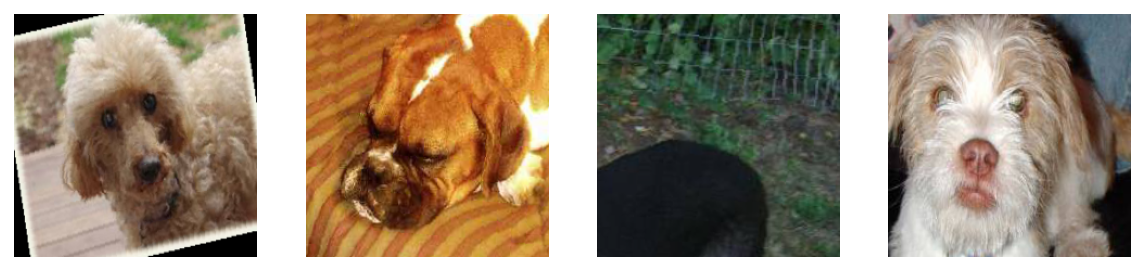

In [4]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print("Training Set Images")
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax = ax, normalize = True)

Test Set Images


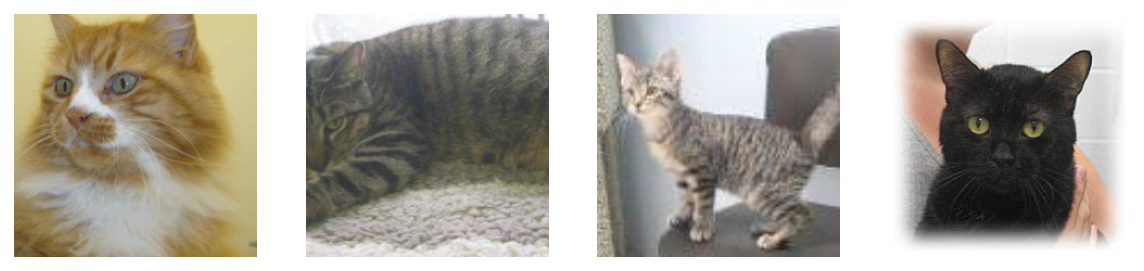

In [5]:
images, labels = next(iter(test_loader))
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print("Test Set Images")
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax = ax, normalize = True)

In [ ]:
data_dir = r"Cat_Dog_data"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_dataset = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64)

We can load in a model such as DenseNet. Let's print out the model architecture

In [6]:
model = models.densenet121(pretrained = True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own.

In [7]:
# Freezing parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ("fc1", nn.Linear(1024,500)),
                            ("relu", nn.ReLU()),
                            ("fc2", nn.Linear(500,2)),
                            ("output", nn.LogSoftmax(dim=1))]))
model.classifier = classifier

In [8]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [10]:
for device in ['cpu', 'cuda']:
    
    criterion = nn.NLLLoss()
    
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)
    
    #Assign device to the model
    model.to(device)
    
    start = time.time()
    i = 0
    for images, labels in train_loader:
        
        #Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)

        logps = model(images)
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i += 1
        if i == 30: break
        
    print(f"Device = {device}  Time per batch   = {(time.time() - start)/30:.3f} seconds")
    print(f'Device = {device}  Total Time Taken = {(time.time() - start)/60:.2f} mins\n')

Device = cpu  Time per batch   = 7.758 seconds
Device = cpu  Total Time Taken = 3.88 mins

Device = cuda  Time per batch   = 0.608 seconds
Device = cuda  Total Time Taken = 0.30 mins

